In [2]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
from termcolor import colored
import ast
import csv
import json 
import scipy.io

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
mat = scipy.io.loadmat('/content/gdrive/My Drive/Research/Characters/mixoutALL_shifted.mat')

In [5]:
mat['consts']

array([[(array([[1]], dtype=uint8), array(['outfileABCDEGHLMNOPQRSUVWYZ.csv'], dtype='<U31'), array([[250]], dtype=uint8), array([[array(['a'], dtype='<U1'), array(['b'], dtype='<U1'),
        array(['c'], dtype='<U1'), array(['d'], dtype='<U1'),
        array(['e'], dtype='<U1'), array(['g'], dtype='<U1'),
        array(['h'], dtype='<U1'), array(['l'], dtype='<U1'),
        array(['m'], dtype='<U1'), array(['n'], dtype='<U1'),
        array(['o'], dtype='<U1'), array(['p'], dtype='<U1'),
        array(['q'], dtype='<U1'), array(['r'], dtype='<U1'),
        array(['s'], dtype='<U1'), array(['u'], dtype='<U1'),
        array(['v'], dtype='<U1'), array(['w'], dtype='<U1'),
        array(['y'], dtype='<U1'), array(['z'], dtype='<U1')]],
      dtype=object), array([[ 1,  1,  1, ..., 20, 20, 20]], dtype=uint8), array([[0.005]]), array([[20]], dtype=uint8), array([[2]], dtype=uint8), array([[3]], dtype=uint8), array(['yes'], dtype='<U3'), array([[0.005     ],
       [0.005     ],
       [0.

In [6]:
labels = mat['consts'][0][0][4][0]
labels

array([ 1,  1,  1, ..., 20, 20, 20], dtype=uint8)

In [7]:
Data = [0] * len(mat['mixout'][0])
for j in range(len(Data)):
    Data[j] = [0] * len(mat['mixout'][0][j][0])
    Data[j][0] = np.zeros(2)
    for i in range(1, len(mat['mixout'][0][j][0])):
        Data[j][i] = Data[j][i-1] + mat['mixout'][0][j][:2, i]
    Data[j] = np.array(Data[j])
        
Data = np.array(Data)
Data.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


(2858,)

# ${\rm d}_Q^{\sigma}$ distance

In [8]:
def dist_signed_point_closed(Q, gamma, sigma): 
    
    p1 = gamma[:-1]
    p2 = gamma[1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    II = np.where(L > 10e-6)[0]
    p1 = p1[II]
    p2 = p2[II]
    gamma = np.array(list(p1) + [p2[-1]])
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1)) + 10e-6
    
    w = (p1-p2)*(-1,1)/(L * np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
# signed distance to the extended lines of segments
    dist_signed = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    x = abs(dist_signed.copy())
    R = (L**2).reshape(-1,1)
# u = argmin points on the extended lines of segments
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)

    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
# d1 = distance to start points
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
# d2 = distance to end points
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))
    d = np.where(d1 < d2, d1, d2)
    dist_segment = np.where(abs(G + H - L) < np.ones(len(L)) * (10e-6), dist_signed, d)
    
    J2 = [0] * len(Q)
    for i in range(len(Q)): 
        J2[i] = np.where(abs(G + H - L)[i] > 10e-6)[0]
    J2 = np.array(J2)

    dist_segment_copy = dist_segment.copy()
    dist = abs(dist_segment_copy)


    j = np.argmin(dist, axis =1)

    sign = np.ones(len(Q))
    for k in range(len(Q)): 
        if j[k] in J2[k]:
            if j[k] == 0 and LA.norm(Q[k] - gamma[0]) < LA.norm(Q[k] - gamma[1]):
                
                y = LA.norm(gamma[0]-gamma[1]) - LA.norm(gamma[-1] - gamma[-2])
                if y < 0:
                    x = gamma[0] + 0.1 * LA.norm(gamma[0]-gamma[1])*(gamma[-2]-gamma[-1])/LA.norm(gamma[-2]-gamma[-1])
                    z = gamma[0] + 0.1 * LA.norm(gamma[0]-gamma[1])*(gamma[1]-gamma[0])/LA.norm(gamma[1]-gamma[0])
                    q = 2 * gamma[0] - (x + z)/2
                else: 
                    x = gamma[0] + 0.1 * LA.norm(gamma[-1]-gamma[-2])*(gamma[1]-gamma[0])
                    z = gamma[0] + 0.1 * LA.norm(gamma[-1]-gamma[-2])*(gamma[-2]-gamma[-1])
                    q = 2 * gamma[0] - (x + z)/2
                sign[k] = np.sign((q-gamma[-1]).dot(w[-1] + w[0]))
                
            elif j[k] == len(gamma)-2 and LA.norm(Q[k] - gamma[-1]) < LA.norm(Q[k] - gamma[-2]):
                s = w[-1].dot((Q[k] - gamma[-1])/ LA.norm(Q[k] - gamma[-1]) + 10e-6)
                sign[k] = np.sign(s)
            
            elif LA.norm(Q[k] - gamma[j[k]]) < LA.norm(Q[k] - gamma[j[k]+1]):  
                q = 2 * gamma[j[k]] - (gamma[j[k]-1] + gamma[j[k]+1])/2
                sign[k] = np.sign((q-gamma[j[k]]).dot(w[j[k]-1] + w[j[k]]))
                    
            elif LA.norm(Q[k] - gamma[j[k]+1]) <= LA.norm(Q[k] - gamma[j[k]]):
                q = 2 * gamma[j[k]+1] - (gamma[j[k]] + gamma[j[k]+2])/2
                sign[k] = np.sign((q-gamma[j[k]+1]).dot(w[j[k]] + w[j[k]+1]))

    E = dist_segment[np.arange(len(dist_segment)),j] 
    F = dist[np.arange(len(dist)),j] 
    dist_weighted = sign * (1/sigma) * (E.reshape(-1,1) * np.exp(-(F/sigma)**2).reshape(-1,1)).reshape(1,-1)
  
    return dist_weighted.reshape(len(Q))

In [9]:
def dist_signed_point_unclosed(Q, gamma, sigma): 
    
    h = 10e-8
    p1 = gamma[:-1]
    p2 = gamma[1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    II = np.where(L > h)[0]
    p1 = p1[II]
    p2 = p2[II]
    gamma = np.array(list(p1) + [p2[-1]]) 
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1)) 
    w = (p1-p2)*(-1,1)/(L * np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
# signed distance to the extended lines of segments
    dist_signed = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    b = dist_signed + 0
    x = abs(b)
    R = (L**2).reshape(-1,1)

# u = argmin points on the extended lines of segments
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)

    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
# d1 = distance to start points
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
# d2 = distance to end points
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))
    d = np.where(d1 < d2, d1, d2)

    dist_segment = np.where(abs(G + H - L) < np.ones(len(L)) * 2*h, dist_signed, d)

    J2 = [0] * len(Q)
    for i in range(len(Q)): 
        J2[i] = np.where(abs(G + H - L)[i] > 2 * h)[0]
    J2 = np.array(J2, dtype = 'object')
    
    dist_segment_copy = dist_segment + 0
    dist = abs(dist_segment_copy)
    
    dist_from_start_1 = np.sqrt(((Q -p1[0])*(Q -p1[0])).sum(axis =1))
    ds_1 = ((Q -p1[0])*w[0]).sum(axis =1)
    dist_from_start = ds_1 * np.maximum(abs(ds_1), np.sqrt(dist_from_start_1**2 - ds_1**2 + 
                                                        h))/ (dist_from_start_1 + h)

    dist_from_end_1 = np.sqrt(((Q -p2[-1])*(Q -p2[-1])).sum(axis =1))
    de_1 = ((Q -p2[-1])* w[-1]).sum(axis =1)
    dist_from_end = de_1 * np.maximum(abs(de_1), np.sqrt(dist_from_end_1**2 - 
                                                de_1**2 + h))/ (dist_from_end_1+ h)
    
    dist_segment[:,0] = np.where(abs(dist[:,0]- dist_from_start_1)< h**2, 
                                 dist_from_start, dist_segment[:,0]) 
    
    dist_segment[:,-1] = np.where(abs(dist[:,-1]- dist_from_end_1)< h**2, 
                                  dist_from_end, dist_segment[:,-1]) 

    j = np.argmin(dist, axis =1)
    sign = np.ones(len(Q))
    for k in range(len(Q)): 
        if j[k] in J2[k]: 
            if j[k] == 0 and LA.norm(Q[k] - gamma[0]) < LA.norm(Q[k] - gamma[1]):
                sign[k] = 1
                
            elif j[k] == len(gamma)-2 and LA.norm(Q[k] - gamma[j[k]+1]) < LA.norm(Q[k] - 
                                                                            gamma[j[k]]):
                sign[k] = 1
            elif LA.norm(Q[k] - gamma[j[k]]) < LA.norm(Q[k] - gamma[j[k]+1]):  
                q = 2 * gamma[j[k]] - (gamma[j[k]-1] + gamma[j[k]+1])/2
                sign[k] = np.sign((q-gamma[j[k]]).dot(w[j[k]-1] + w[j[k]]))
            elif LA.norm(Q[k] - gamma[j[k]+1]) <= LA.norm(Q[k] - gamma[j[k]]):
                q = 2 * gamma[j[k]+1] - (gamma[j[k]] + gamma[j[k]+2])/2
                sign[k] = np.sign((q-gamma[j[k]+1]).dot(w[j[k]] + w[j[k]+1]))
    E = dist_segment[np.arange(len(dist_segment)),j] 
    F = dist[np.arange(len(dist)),j] 
    dist_weighted = (1/sigma) * sign * (E.reshape(-1,1) *
                        np.exp(-(F/sigma)**2).reshape(-1,1)).reshape(1,-1)

    return dist_weighted.reshape(len(Q))

In [10]:
def dist_signed_point(Q, gamma, sigma):
    
    if LA.norm(gamma[0]-gamma[-1]) > 10e-6:
        A = dist_signed_point_unclosed(Q, gamma, sigma)
    else: 
        A = dist_signed_point_closed(Q, gamma, sigma)
        
    return A

# ${\rm d}_Q^{\rm mD}$ distance

In [11]:
def old_dist(Q, gamma):
    
    p2 = gamma[1:]
    p1 = gamma[:-1]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    II = np.where(L>10e-8)[0]
    L = L[II]
    p1 = p1[II]
    p2 = p2[II]
    w = (p1-p2)*(-1,1)/(L*np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
    dist_dot = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    
    x = abs(dist_dot.copy())
    R = (L**2).reshape(-1,1)
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)
    
    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))

    dist = np.where(abs(G + H - L) < np.ones(len(L)) * (10e-8), x, np.minimum(d1, d2))

    j = np.argmin(dist, axis =1)
    dist_weighted = dist[np.arange(len(dist)),j] 
    
    return dist_weighted.reshape(len(Q)) 

# Classifiers

In [97]:
clf0 = svm.SVC(C=1000, kernel='linear') 
clf1 = make_pipeline(StandardScaler(), svm.SVC(C= 1, kernel = 'rbf', gamma= 'auto', max_iter = 200000))
clf2 = make_pipeline(StandardScaler(), svm.SVC(C= 10, kernel = 'poly', max_iter = 400000))
clf3 = DecisionTreeClassifier() 
clf4 = RandomForestClassifier(n_estimators=100) 

clf = [clf0,clf1,clf2,clf3,clf4]

## Classification of 20 choose 2 data sets

In [101]:
def classify(n, m, k = 20, sigma = 50, t = 10, std_x = 20, std_y = 20, clf = clf):
    
    I = np.where(labels == n)[0] 
    J = np.where(labels == m)[0]
    K = np.concatenate((I, J), 0)
    
    Min = np.min([np.min(Data[K][i], 0) for i in range(len(Data[K]))], 0)
    Max = np.max([np.max(Data[K][i], 0) for i in range(len(Data[K]))], 0)
    Mean = np.mean([np.mean(Data[K][i], 0) for i in range(len(Data[K]))], 0)
    Std = np.std([np.std(Data[K][i], 0) for i in range(len(Data[K]))], 0)
    
    data_1 = Data[I]
    data_2 = Data[J]
    
    Q = np.ones((k,2))
    Q[:,0] = np.random.normal(Mean[0], Std[0] + std_x, k)
    Q[:,1] = np.random.normal(Mean[1], Std[1] + std_y, k)
    
    for s in range(len(data_1[:5])):
        plt.plot(data_1[s][:,0], data_1[s][:,1], color = "steelblue");
    for s in range(len(data_2[:5])):
        plt.plot(data_2[s][:,0], data_2[s][:,1], color = "red");
    plt.scatter(Q[:,0], Q[:,1], s = 10, color= 'black');
    plt.show()
    
    n_1 = len(data_1)
    n_2 = len(data_2)
    
    # signed distance
    projected_1 = [0] * n_1
    projected_2 = [0] * n_2
    for i in range(n_1):
        projected_1[i] = np.concatenate((dist_signed_point_unclosed(Q,data_1[i],sigma),[1]), 
                                        axis = 0)
    for i in range(n_2):
        projected_2[i] = np.concatenate((dist_signed_point_unclosed(Q,data_2[i],sigma),[-1]), 
                                        axis = 0)
    projected_1 = np.array(projected_1)
    projected_2 = np.array(projected_2)
    
    # old distance
    proj_1 = [0] * n_1 
    proj_2 = [0] * n_2 
    for i in range(n_1):
        proj_1[i] = np.concatenate((old_dist(Q, data_1[i]),[1]), axis = 0)
    for i in range(n_2):
        proj_2[i] = np.concatenate((old_dist(Q, data_2[i]),[-1]), axis = 0)
    proj_1 = np.array(proj_1)
    proj_2 = np.array(proj_2)
    
    error_train = np.zeros((len(clf), t))
    error_test = np.zeros((len(clf), t))
    error_tr = np.zeros((len(clf), t))
    error_ts = np.zeros((len(clf), t))
    
    for i in range(t): 
        R1 = random.sample(range(n_1), n_1//3)
        R = np.sort(R1)
        R_c = np.sort(list(set(range(n_1)) - set(R)))
        S1 = random.sample(range(n_2), n_2//3)
        S = np.sort(S1)
        S_c = np.sort(list(set(range(n_2)) - set(S)))

        data_train = np.insert(projected_1[R_c], len(R_c), projected_2[S_c], axis = 0)
        data_test = np.insert(projected_1[R], len(R), projected_2[S], axis = 0)
        data_tr = np.insert(proj_1[R_c], len(R_c), proj_2[S_c], axis = 0)
        data_ts = np.insert(proj_1[R], len(R), proj_2[S], axis = 0)

        random.shuffle(data_train)
        random.shuffle(data_test)
        random.shuffle(data_tr)
        random.shuffle(data_ts)

        for s in range(len(clf)):
            model = clf[s]
            
            model.fit(data_train[:,:-1], data_train[:,-1])
            y_pred = model.predict(data_test[:,:-1])
            error_test[s][i] = 1 - metrics.accuracy_score(data_test[:,-1], y_pred)
            x_pred = model.predict(data_train[:,:-1])
            error_train[s][i] = 1 - metrics.accuracy_score(data_train[:,-1], x_pred)

            model.fit(data_tr[:,:-1], data_tr[:,-1])
            y_pre = model.predict(data_ts[:,:-1])
            error_ts[s][i] = 1 - metrics.accuracy_score(data_ts[:,-1], y_pre)
            x_pre = model.predict(data_tr[:,:-1])
            error_tr[s][i] = 1 - metrics.accuracy_score(data_tr[:,-1], x_pre)

    Dic = {}
    models = ["L SVM, C=1000", "G SVM, C=1", #"G SVM, C=2", "G SVM, C=10", 
              "P SVM, C=10", "DTree", "RForest, n=100"]
    for l in range(len(models)): 
        Dic[l+1] = [models[l], np.round(np.mean(error_train[l]), decimals = 4), 
                     np.round(np.mean(error_test[l]), decimals = 4),
                     np.round(np.std(error_test[l]), decimals = 4),
                     '|',
                     np.round(np.mean(error_tr[l]), decimals = 4), 
                     np.round(np.mean(error_ts[l]), decimals = 4),
                     np.round(np.std(error_ts[l]), decimals = 4)]
    
    print("n, m =", (n, m))
    
    print(pd.DataFrame.from_dict(Dic, 
                                 orient='index', 
                                 columns=['Classifier', 'Train N', 'Test N', 'Std N', 
                                          '|','Train O', 'Test O', 'Std O']))
    print("Q =", Q)
    return n, m, sigma, t, Q

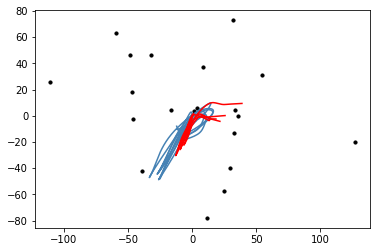

n, m = (12, 14)
       Classifier  Train N  Test N   Std N  |  Train O  Test O   Std O
1   L SVM, C=1000   0.0031  0.0176  0.0235  |   0.0000  0.0401  0.0356
2      G SVM, C=1   0.0038  0.0124  0.0151  |   0.0091  0.0381  0.0268
3     P SVM, C=10   0.0011  0.0281  0.0224  |   0.0070  0.0483  0.0345
4           DTree   0.0000  0.0178  0.0284  |   0.0000  0.0737  0.0465
5  RForest, n=100   0.0000  0.0100  0.0138  |   0.0000  0.0486  0.0330
Q = [[-3.24902653e+01  4.60044218e+01]
 [-1.68353212e+01  4.43267019e+00]
 [-1.10587361e+02  2.59348076e+01]
 [ 2.92457830e+01 -3.99858732e+01]
 [ 1.17810639e+01 -7.79407977e+01]
 [ 3.53840384e+01 -1.25123595e-01]
 [ 1.26823738e+02 -1.99258348e+01]
 [ 5.42110442e+01  3.10153988e+01]
 [ 1.52758301e+00  3.62917151e+00]
 [-4.62751522e+01 -2.46585474e+00]
 [ 3.25632345e+01 -1.34574254e+01]
 [ 3.96964624e+00  6.12114622e+00]
 [-4.71061489e+01  1.78451989e+01]
 [ 3.30163320e+01  4.06856467e+00]
 [-3.91222051e+01 -4.19573723e+01]
 [-5.90871676e+01  6.29764287

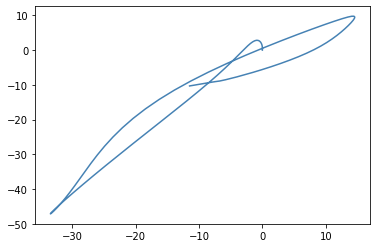

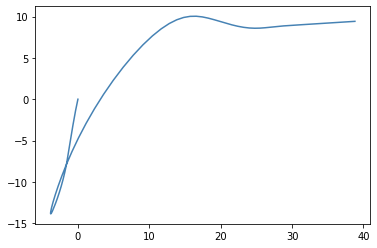

In [99]:
n = 12
m = 14

A = classify(n = n, m = m, k = 20, sigma = 1000,  t = 1000, std_x = 50, 
         std_y = 50, clf = clf)

I = np.where(labels == n)[0] 
J = np.where(labels == m)[0]
plt.plot(Data[I][0][:,0], Data[I][0][:,1], color = "steelblue")
plt.show()
plt.plot(Data[J][0][:,0], Data[J][0][:,1], color = "steelblue")
plt.show()

In [100]:
A[-1]

array([[-3.24902653e+01,  4.60044218e+01],
       [-1.68353212e+01,  4.43267019e+00],
       [-1.10587361e+02,  2.59348076e+01],
       [ 2.92457830e+01, -3.99858732e+01],
       [ 1.17810639e+01, -7.79407977e+01],
       [ 3.53840384e+01, -1.25123595e-01],
       [ 1.26823738e+02, -1.99258348e+01],
       [ 5.42110442e+01,  3.10153988e+01],
       [ 1.52758301e+00,  3.62917151e+00],
       [-4.62751522e+01, -2.46585474e+00],
       [ 3.25632345e+01, -1.34574254e+01],
       [ 3.96964624e+00,  6.12114622e+00],
       [-4.71061489e+01,  1.78451989e+01],
       [ 3.30163320e+01,  4.06856467e+00],
       [-3.91222051e+01, -4.19573723e+01],
       [-5.90871676e+01,  6.29764287e+01],
       [ 3.21785601e+01,  7.29091697e+01],
       [-4.83503786e+01,  4.61095240e+01],
       [ 2.50696612e+01, -5.74618787e+01],
       [ 8.60611470e+00,  3.69777691e+01]])